# Instalação

Libs necessárias: pip install -r requirements.txt

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings

# 0. Lendo o arquivo

In [60]:
df = pd.read_csv( 'dataset/top10K-TMDB-movies.csv' )
df.shape

(10000, 9)

# 1. Pré-processamento da base de dados

## 1.1 Valores Ausentes

### 1.1.1 Ver se há algum valor ausente no DataFrame

Retorna `True` se houver pelo menos um valor ausente.

In [61]:
df.isnull().values.any()

np.True_

### 1.1.2 Contar quantos valores ausentes há em cada coluna

In [62]:
df.isnull().sum()

id                    0
title                 0
genre                 3
original_language     0
overview             13
popularity            0
release_date          0
vote_average          0
vote_count            0
dtype: int64

### 1.1.3 Exibir linhas que possuem valores ausentes

In [63]:
df[ df.isnull().any( axis = 1 ) ]

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count
3361,50472,Anplagghed al cinema,NaN,it,"A queue at the ATM machine, a displaced family...",4.420,2006-11-26,7.0,313
4150,38537,Nati stanchi,Comedy,it,NaN,5.671,2002-03-01,6.8,211
6973,31359,Would I Lie to You? 2,Comedy,fr,NaN,4.741,2001-02-07,6.2,325
7821,43211,7 Kilos in 7 Days,NaN,it,Two not very clever young doctors open a fitne...,5.885,1986-02-02,6.0,212
7941,2029,Tanguy,Comedy,fr,NaN,5.449,2001-11-21,6.0,387
8518,57114,"Amore, bugie e calcetto",NaN,en,NaN,4.709,2008-04-04,5.8,200
9293,17413,Incognito,Comedy,fr,NaN,5.602,2009-04-28,5.5,213
9440,516043,Arrivano i prof,Comedy,it,NaN,6.558,2018-05-01,5.4,337
9620,154512,Lightning Strike,Comedy,it,NaN,4.070,2012-12-13,5.3,216
9792,42426,A spasso nel tempo - L'avventura continua,"Comedy,Fantasy",it,NaN,5.020,1997-12-11,5.1,209


### 1.1.4 Removendo linhas com valores ausentes

In [64]:
df.dropna( subset = [ 'overview' ], inplace = True )
df.reset_index( drop = True, inplace = True )

## 1.2 Valores Duplicados

### 1.2.1 Ver se há alguma linha duplicada

Retorna `True` se houver ao menos uma linha duplicada

In [65]:
df.duplicated().any()

np.False_

### 1.2.2 Contar o número de linhas duplicadas

In [66]:
df.duplicated().sum()

np.int64(0)

### 1.2.3 Ver quais são as linhas duplicadas

In [67]:
df[ df.duplicated() ]

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count


# 2. Seleção de Atributos

In [68]:
df = df[ [ 'id', 'title', 'overview', "genre" ] ]
df.shape

(9987, 4)

In [69]:
df[ 'tags' ] = df[ 'overview' ] + df[ 'genre' ]
df.shape

(9987, 5)

In [70]:
df_new = df.drop( columns = [ 'overview', 'genre' ] )
df_new.shape

(9987, 3)

# 2. Similaridade de Cossenos

Imagine que cada sinopse de filme, depois de ser transformada em números (seja por Bag of Words ou TF-IDF), se torna um vetor em um espaço com muitas dimensões (onde cada dimensão corresponde a uma palavra do vocabulário).

## 2.1 **A Ideia Central**

A similaridade de cossenos **não mede a distância** entre as pontas desses vetores, mas sim o ângulo entre eles.

- Se dois vetores apontam para **direções muito parecidas**, o ângulo entre eles é pequeno, e a similaridade de cossenos é alta (próxima de 1). Isso sugere que as sinopses usam palavras/termos de forma parecida, indicando temas semelhantes.
- Se dois vetores apontam para **direções completamente diferentes** (são ortogonais, formam um ângulo de 90 graus), a similaridade de cossenos é 0. Isso sugere que as sinopses tratam de assuntos muito distintos, com poucas palavras-chave em comum.
- Se dois vetores apontam para **direções opostas**, o ângulo é de 180 graus, e a similaridade de cossenos é -1. Na prática, com vetores de texto baseados em contagens (BoW) ou TF-IDF, que geralmente não têm valores negativos, a similaridade varia entre 0 e 1.

## 2.2 **Exemplo**

Vamos simplificar muito e imaginar um vocabulário minúsculo com apenas 3 palavras: "ação", "comédia", "drama".

Agora, vamos representar 3 filmes com vetores baseados na contagem dessas palavras em suas (hipotéticas) sinopses:

- Filme A: "Muita ação e um pouco de drama."
    - Vetor A = [ação: 2, comédia: 0, drama: 1] -> [2, 0, 1]
- Filme B: "Pura ação!"
    - Vetor B = [ação: 1, comédia: 0, drama: 0] -> [1, 0, 0]
- Filme C: "Uma comédia dramática."
    - Vetor C = [ação: 0, comédia: 1, drama: 1] -> [0, 1, 1]

Agora, vamos calcular a similaridade de cossenos (sem entrar nos detalhes matemáticos exatos aqui, apenas a intuição):

- Similaridade(A, B):
    - Ambos têm "ação". O Filme A também tem "drama", o Filme B não.
    - Os vetores [2, 0, 1] e [1, 0, 0] apontam em direções relativamente parecidas (ambos têm um forte componente na dimensão "ação").
    - A similaridade de cossenos será alta, mas não 1 (porque A também tem "drama").
- Similaridade(A, C):
    - Ambos têm "drama". O Filme A tem "ação", o Filme C tem "comédia".
    - Os vetores [2, 0, 1] e [0, 1, 1] compartilham a dimensão "drama", mas divergem nas outras ("ação" vs "comédia").
    - A similaridade de cossenos será média-baixa.
- Similaridade(B, C):
    - Não compartilham nenhuma palavra do nosso vocabulário ("ação" vs "comédia", "drama").
    - Os vetores [1, 0, 0] e [0, 1, 1] apontam em direções muito diferentes.
    - A similaridade de cossenos será próxima de 0.

## 2.3 **Matematicamente**

A fórmula é:

$$
\text{similaridade(A,B)} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

Onde:
- $ \mathbf{A} \cdot \mathbf{B} $ é o produto escalar dos vetores (soma da multiplicação de cada componente correspondente).
- $ \|\mathbf{A}\|$ e $ \|\mathbf{B}\| $ são as magnitudes (ou "comprimentos") dos vetores.

# 3. Vetorização das Sinopses

Para que os algoritmos de machine learning compreendam e processem dados textuais, como as sinopses ou tags dos filmes, precisamos primeiro convertê-los em vetores numéricos. Bag of Words (BoW) e TF-IDF são duas abordagens fundamentais e amplamente utilizadas para essa tarefa de **vetorização**.

## 3.1 Bag of Worlds (BoW)

Como primeira abordagem, utilizamos o Bag of Words (BoW). Este método representa os textos contando a frequência de cada palavra, de forma simples e direta.

**Expectativa:** Espera-se que o BoW capture similaridades baseadas na sobreposição direta de palavras-chave entre as 'tags' dos filmes. Recomendações podem ser relevantes se os filmes compartilham muitos termos descritivos, mas podem também ser influenciadas por palavras muito comuns (mesmo com stop words removidas) ou falhar em capturar relações de significado mais sutis que não envolvam as mesmas palavras exatas. É um ponto de partida para estabelecermos uma linha de base.

In [71]:
bow_vectorizer = CountVectorizer( max_features = 10000, stop_words = 'english' )
bow_matrix = bow_vectorizer.fit_transform( df_new[ 'tags' ].values.astype( 'U' ) ).toarray()

cosine_sim_bow = cosine_similarity( bow_matrix )

## 3.2 TF-IDF (Term Frequency-Inverse Document Frequency)

Agora, aplicamos o TF-IDF. Diferente do BoW que trata todas as palavras igualmente, o TF-IDF atribui um peso maior às palavras que são frequentes em um documento específico, mas raras no conjunto geral de documentos. Isso ajuda a destacar termos mais discriminativos.

**Expectativa:** Com o TF-IDF, espera-se uma melhoria em relação ao BoW. Ao dar mais importância a palavras potencialmente mais significativas e reduzir o peso de termos muito genéricos, as recomendações podem se tornar mais focadas nos aspectos distintivos dos filmes. É possível que vejamos recomendações mais precisas, menos influenciadas por palavras excessivamente comuns nas 'tags'.

In [72]:
tfidf_vectorizer = TfidfVectorizer( max_features = 10000, stop_words = 'english' )
tfidf_matrix = tfidf_vectorizer.fit_transform( df_new[ 'tags' ].values.astype( 'U' ) ).toarray()

cosine_sim_tfidf = cosine_similarity( tfidf_matrix )

# 4. Recomendação Baseada em Similaridade

Avançamos agora para uma técnica mais moderna e sofisticada: Sentence-BERT. Diferente do BoW e TF-IDF (que focam em palavras isoladas), o SBERT utiliza modelos Transformer pré-treinados para gerar embeddings que capturam o *significado semântico* do texto como um todo, considerando o contexto das palavras.

**Expectativa:** A expectativa aqui é um salto qualitativo nas recomendações. O SBERT deve ser capaz de identificar filmes similares mesmo que eles não usem exatamente as mesmas palavras-chave em suas 'tags', mas expressem ideias ou temas semanticamente próximos. Espera-se que as recomendações sejam mais contextuais, relevantes e capazes de capturar nuances de significado que os métodos anteriores não conseguiam.

## 4.1 Criação do Mapeamento Título -> Índice

Cria uma estrutura de dados (Pandas Series) que permite encontrar rapidamente o índice de um filme no DataFrame a partir do seu título. Isso otimiza as buscas dentro da função de recomendação. `drop_duplicates()` garante que, se houver títulos idênticos, apenas o primeiro índice seja mantido no mapeamento.

In [73]:
if 'df' in globals() and isinstance( df, pd.DataFrame ) and 'title' in df.columns:
    # Cria a Série: index é o título, valor é o índice original do DataFrame
    indices = pd.Series( df.index, index = df[ 'title' ] ).drop_duplicates()
    print( "Mapeamento Título -> Índice ('indices') criado com sucesso." )
else:
    print( "Erro: DataFrame 'df' ou coluna 'title' não encontrada. Não foi possível criar o mapeamento 'indices'." )
    # Define indices como None para que as funções de recomendação falhem de forma controlada
    indices = None

Mapeamento Título -> Índice ('indices') criado com sucesso.


## 4.2 Definição da Função `recommend_by_synopsis`

Define a função que recebe um título de filme e uma matriz de similaridade. Ela usa o mapeamento 'indices' para encontrar o filme, localiza seus scores de similaridade na matriz, ordena os outros filmes por similaridade decrescente e retorna os 'top_n' mais similares junto com seus scores.

In [74]:
def recommend_by_synopsis( titulo, cosine_sim_matrix, data = df, mapping = indices, top_n = 10 ):
    """
    Gera recomendações de filmes baseadas na similaridade de vetores.

    Retorna os títulos e suas pontuações de similaridade com o filme de entrada.

    Args:
        titulo (str): O título do filme base para a recomendação.
        cosine_sim_matrix (np.array): Matriz de similaridade de cossenos pré-calculada.
                                      Pode ser None se ocorreu erro no cálculo.
        data (pd.DataFrame): DataFrame contendo pelo menos 'title'.
        mapping (pd.Series): Mapeamento de títulos para índices do DataFrame.
                             Pode ser None se ocorreu erro na criação.
        top_n (int): Número de recomendações a serem retornadas.

    Returns:
        list: Lista de tuplas (titulo_recomendado, similaridade), ou str com erro.
    """
    # Validações iniciais
    if cosine_sim_matrix is None:
        return f"Erro: Matriz de similaridade não fornecida ou inválida."
    if mapping is None:
        return f"Erro: Mapeamento Título->Índice ('indices') não está disponível."
    if not isinstance( data, pd.DataFrame ) or 'title' not in data.columns:
        return f"Erro: DataFrame 'data' inválido ou sem coluna 'title'."

    try:
        # --- Encontra o índice do filme de entrada ---
        if titulo not in mapping:
            # Busca flexível (case-insensitive, sem espaços extras)
            matches = [ t for t in mapping.index if
                        isinstance( t, str ) and t.lower().strip() == titulo.lower().strip() ]
            if not matches: raise KeyError  # Dispara erro se não encontrar
            actual_title = matches[ 0 ]
            idx = mapping[ actual_title ]
            print( f"Nota: Buscando por '{actual_title}' (match para '{titulo}')" )
        else:
            idx = mapping[ titulo ]  # Índice do filme de entrada

        # Valida o índice
        if idx >= len( cosine_sim_matrix ):
            raise ValueError(
                    f"Índice {idx} (para '{titulo}') está fora dos limites da matriz de similaridade ({len( cosine_sim_matrix )})." )

        # --- Calcula e Ordena Similaridades ---
        # Obtém as pontuações de similaridade do filme 'idx' com todos os outros
        sim_scores = list( enumerate( cosine_sim_matrix[ idx ] ) )

        # Ordena pela similaridade (item [1] da tupla), decrescente
        sim_scores = sorted( sim_scores, key = lambda x: x[ 1 ], reverse = True )

        # --- Seleciona Top N e Formata Saída ---
        # Seleciona os top_n mais similares (excluindo o próprio filme - índice 1 em diante)
        sim_scores = sim_scores[ 1:top_n + 1 ]

        # Monta a lista de resultados (título, score)
        recomendacoes = [ ]
        for index, score in sim_scores:
            # Checa se o índice do filme recomendado é válido no DataFrame 'data'
            if index < len( data ):
                titulo_filme = data[ 'title' ].iloc[ index ]
                recomendacoes.append( (titulo_filme, score) )
            # else: # Opcional: Avisar sobre índice inválido
            #    print(f"Aviso: Índice de recomendação {index} fora dos limites do DataFrame. Ignorando.")

        if not recomendacoes:
            return "Nenhuma recomendação encontrada (após filtrar o próprio filme)."

        return recomendacoes

    except KeyError:
        suggestion = [ t for t in mapping.index if isinstance( t, str ) and titulo.lower() in t.lower() ][
                     :5 ]  # Sugestões simples
        error_msg = f"Erro: Filme '{titulo}' não encontrado no dataset."
        if suggestion: error_msg += f" Títulos similares: {suggestion}"
        return error_msg
    except ValueError as ve:
        return f"Erro de valor ao processar '{titulo}': {ve}"
    except Exception as e:
        import traceback
        print( f"Erro inesperado em recommend_by_synopsis para '{titulo}': {type( e ).__name__} - {e}" )
        # traceback.print_exc() # Descomente para ver o stack trace completo
        return "Ocorreu um erro inesperado durante a recomendação por similaridade."

## 4.3 Aplicação: Recomendações com BoW e TF-IDF

Utiliza a função `recommend_by_synopsis` para gerar recomendações para um filme de exemplo, usando as matrizes de similaridade calculadas anteriormente com Bag of Words (`cosine_sim_bow`) e TF-IDF (`cosine_sim_tfidf`). Os resultados de cada método são impressos para comparação.

In [ ]:
print( "\n--- Testando Recomendações por Similaridade (BoW e TF-IDF) ---" )

# Define o filme de exemplo
filme_exemplo = "The Dark Knight Rises"
print( f"Filme de exemplo: '{filme_exemplo}'" )

# --- Teste com BoW ---
print( f"\n--- Recomendações para '{filme_exemplo}' (BoW) ---" )
# Verifica se a matriz BoW e o mapeamento 'indices' estão disponíveis
if 'cosine_sim_bow' in globals() and cosine_sim_bow is not None and indices is not None:
    recomendacoes_bow = recommend_by_synopsis( filme_exemplo, cosine_sim_matrix = cosine_sim_bow, top_n = 5 )
    # Imprime o resultado
    if isinstance( recomendacoes_bow, list ):
        if not recomendacoes_bow:
            print( "Nenhuma recomendação BoW encontrada." )
        else:
            for i, (filme, score) in enumerate( recomendacoes_bow ): print(
                    f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recomendacoes_bow )  # Exibe a mensagem de erro
else:
    print( "Não foi possível gerar recomendações BoW (dependências ausentes: 'cosine_sim_bow' ou 'indices')." )

# --- Teste com TF-IDF ---
print( f"\n--- Recomendações para '{filme_exemplo}' (TF-IDF) ---" )
# Verifica se a matriz TF-IDF e o mapeamento 'indices' estão disponíveis
if 'cosine_sim_tfidf' in globals() and cosine_sim_tfidf is not None and indices is not None:
    recomendacoes_tfidf = recommend_by_synopsis( filme_exemplo, cosine_sim_matrix = cosine_sim_tfidf, top_n = 5 )
    # Imprime o resultado
    if isinstance( recomendacoes_tfidf, list ):
        if not recomendacoes_tfidf:
            print( "Nenhuma recomendação TF-IDF encontrada." )
        else:
            for i, (filme, score) in enumerate( recomendacoes_tfidf ): print(
                    f"{i + 1}. {filme} (Similaridade: {score:.3f})" )
    else:
        print( recomendacoes_tfidf )  # Exibe a mensagem de erro
else:
    print( "Não foi possível gerar recomendações TF-IDF (dependências ausentes: 'cosine_sim_tfidf' ou 'indices')." )

# 5. Vetorização Semântica (Sentence-BERT)

Nesta seção, utiliza-se um modelo Sentence-BERT pré-treinado para gerar embeddings (vetores) que capturam o significado semântico das 'tags' dos filmes. Esta abordagem visa superar as limitações do BoW e TF-IDF, que se baseiam principalmente na frequência de palavras, capturando relações de significado mais profundas. O processo inclui salvar/carregar os embeddings para otimizar execuções futuras e o cálculo da matriz de similaridade baseada nesses embeddings.

## 5.1 Configuração do Modelo e Arquivo de Embeddings

Define qual modelo Sentence-BERT será utilizado (aqui, 'all-mpnet-base-v2', otimizado para inglês) e o nome do arquivo `.npy` onde os embeddings serão salvos ou de onde serão carregados.

In [76]:
# --- Configurações ---
MODEL_NAME_SBERT = 'all-mpnet-base-v2'
# Nome do arquivo para salvar/carregar embeddings
# (Usando o nome fixo do script original do usuário)
EMBEDDINGS_FILE_SBERT = 'movie_tags_embeddings_sbert.npy'

print( f"Modelo SBERT selecionado: {MODEL_NAME_SBERT}" )
print( f"Arquivo para embeddings: {EMBEDDINGS_FILE_SBERT}" )

Modelo SBERT selecionado: all-mpnet-base-v2
Arquivo para embeddings: movie_tags_embeddings_sbert.npy


## 5.2 Geração ou Carregamento dos Embeddings SBERT

Verifica se o arquivo `.npy` com os embeddings já existe.
- Se existir, carrega os embeddings do arquivo (rápido).
- Se não existir (ou ocorrer erro ao carregar), carrega o modelo Sentence-BERT (pode baixar na primeira vez), gera os embeddings para todas as 'tags' (processo demorado) e salva o resultado no arquivo `.npy` para uso futuro.

In [77]:
embeddings_sbert = None  # Inicializa a variável

# Verifica se o arquivo existe
if os.path.exists( EMBEDDINGS_FILE_SBERT ):
    print( f"\nTentando carregar embeddings pré-calculados de '{EMBEDDINGS_FILE_SBERT}'..." )
    try:
        embeddings_sbert = np.load( EMBEDDINGS_FILE_SBERT )
        print( f"Embeddings carregados com sucesso. Shape: {embeddings_sbert.shape}" )
        # Validação: compara o número de embeddings com o número de linhas em df_new
        # Presume que df_new (com id, title, tags) existe, conforme script original
        if 'df_new' in globals() and isinstance( df_new, pd.DataFrame ):
            if embeddings_sbert.shape[ 0 ] != len( df_new ):
                print(
                        f"Aviso: Número de embeddings ({embeddings_sbert.shape[ 0 ]}) "
                        f"não corresponde ao tamanho do DataFrame df_new ({len( df_new )})." )
                print( "Os embeddings serão gerados novamente." )
                embeddings_sbert = None  # Força a regeração
            else:
                print( "Número de embeddings compatível com df_new." )
        else:
            print( "Aviso: DataFrame df_new não encontrado para validação do shape dos embeddings." )
            # Prossegue com os embeddings carregados, mas avisa sobre a impossibilidade de validar o tamanho.

    except Exception as e:
        print( f"Erro ao carregar o arquivo de embeddings '{EMBEDDINGS_FILE_SBERT}': {e}" )
        print( "Os embeddings serão gerados novamente." )
        embeddings_sbert = None

# Gera os embeddings se não foram carregados
if embeddings_sbert is None:
    # Verifica se df_new existe antes de prosseguir
    if 'df_new' not in globals() or not isinstance( df_new, pd.DataFrame ):
        print( "Erro fatal: DataFrame 'df_new' (com a coluna 'tags') não está disponível para gerar embeddings." )
        # Impede a continuação se df_new for essencial e não existir
        # exit() ou levantar uma exceção
    else:
        try:
            # Carrega o modelo SentenceTransformer
            print( f"\nCarregando modelo Sentence-BERT: '{MODEL_NAME_SBERT}' (pode baixar na 1ª vez)..." )
            model_sbert = SentenceTransformer( MODEL_NAME_SBERT )
            print( "Modelo carregado." )

            # Prepara a lista de 'tags' a partir de df_new
            print( "Preparando a lista de 'tags' para codificação (pode levar um momento)..." )
            tags_list = df_new[ 'tags' ].astype( str ).tolist()  # Usa df_new conforme script original

            # Gera os embeddings (etapa demorada)
            print( "\nGerando embeddings com Sentence-BERT... (Processo pode ser demorado)" )
            embeddings_sbert = model_sbert.encode( tags_list, show_progress_bar = True )
            print( f"\nEmbeddings gerados com sucesso! Shape: {embeddings_sbert.shape}" )

            # Salva os embeddings calculados
            try:
                print( f"Salvando embeddings em '{EMBEDDINGS_FILE_SBERT}'..." )
                np.save( EMBEDDINGS_FILE_SBERT, embeddings_sbert )
                print( "Embeddings salvos para uso futuro." )
            except Exception as e:
                print( f"Atenção: Não foi possível salvar os embeddings. Erro: {e}" )

        except ImportError:
            print(
                    "Erro: Biblioteca sentence-transformers não encontrada. Instale com: pip install sentence-transformers" )
        except Exception as e:
            print( f"\nErro crítico durante o processo do Sentence-BERT: {type( e ).__name__} - {e}" )
            print( "Verifique a conexão com a internet e se o modelo é válido." )
            # Garante que embeddings_sbert permaneça None se falhar
            embeddings_sbert = None


Tentando carregar embeddings pré-calculados de 'movie_tags_embeddings_sbert.npy'...
Embeddings carregados com sucesso. Shape: (9987, 768)
Número de embeddings compatível com df_new.


## 5.3 Cálculo da Matriz de Similaridade SBERT

Com os embeddings SBERT (carregados ou recém-gerados) disponíveis, calcula a matriz de similaridade de cossenos entre todos os pares de filmes. Esta matriz (`cosine_sim_sbert`) representa a similaridade semântica entre os filmes, baseada no modelo SBERT.

In [78]:
# Calcula a Similaridade de Cossenos
cosine_sim_sbert = None  # Inicializa
if embeddings_sbert is not None:
    try:
        print( "\nCalculando a matriz de similaridade de cossenos (SBERT)..." )
        # Usa a função do scikit-learn nos embeddings
        cosine_sim_sbert = cosine_similarity( embeddings_sbert )
        print( f"Matriz de similaridade (Sentence-BERT) calculada. Shape: {cosine_sim_sbert.shape}" )
    except Exception as e:
        print( f"Erro ao calcular a similaridade de cossenos com embeddings SBERT: {e}" )
else:
    print( "\nNão foi possível calcular a similaridade SBERT (embeddings não disponíveis)." )


Calculando a matriz de similaridade de cossenos (SBERT)...
Matriz de similaridade (Sentence-BERT) calculada. Shape: (9987, 9987)


## 5.4 Aplicação: Recomendações com SBERT

Utiliza a função `recommend_by_synopsis` (definida na Seção 5) para gerar recomendações para o filme de exemplo, desta vez usando a matriz de similaridade semântica `cosine_sim_sbert`. Os resultados são impressos.

In [79]:
# --- Aplicação da Recomendação SBERT ---
print( "\n--- Testando Recomendações por Similaridade (Sentence-BERT) ---" )

# Presume que 'filme_exemplo' foi definido anteriormente
# Presume que 'recommend_by_synopsis', 'df', e 'indices' estão definidos
if 'filme_exemplo' not in globals():
    filme_exemplo = "Bohemian Rhapsody"  # Define um padrão se não existir
    print( f"Aviso: 'filme_exemplo' não definido, usando '{filme_exemplo}'." )

# Verifica se a matriz de similaridade SBERT foi calculada com sucesso
if cosine_sim_sbert is not None and 'recommend_by_synopsis' in globals() and indices is not None:
    print( f"\n--- Recomendações para '{filme_exemplo}' (Sentence-BERT) ---" )

    recomendacoes_sbert = recommend_by_synopsis(
            filme_exemplo,
            cosine_sim_matrix = cosine_sim_sbert,  # Passa a matriz SBERT
            data = df,  # DataFrame original para buscar títulos
            mapping = indices,  # Mapeamento título->índice
            top_n = 5  # Número de recomendações
    )

    # Imprime o resultado
    if isinstance( recomendacoes_sbert, list ):
        if not recomendacoes_sbert:
            print( "Nenhuma recomendação SBERT encontrada." )
        else:
            for i, (filme, score) in enumerate( recomendacoes_sbert ):
                print( f"{i + 1}. {filme} (Similaridade Semântica: {score:.3f})" )
    else:
        # Imprime a mensagem de erro retornada pela função
        print( recomendacoes_sbert )
else:
    print( "\nNão é possível gerar recomendações com Sentence-BERT." )
    if cosine_sim_sbert is None: print( "  Motivo: Matriz de similaridade SBERT ausente." )
    if 'recommend_by_synopsis' not in globals(): print( "  Motivo: Função 'recommend_by_synopsis' não definida." )
    if indices is None: print( "  Motivo: Mapeamento 'indices' ausente." )


--- Testando Recomendações por Similaridade (Sentence-BERT) ---

--- Recomendações para 'Bohemian Rhapsody' (Sentence-BERT) ---
1. Josie and the Pussycats (Similaridade Semântica: 0.600)
2. Sid and Nancy (Similaridade Semântica: 0.548)
3. American Satan (Similaridade Semântica: 0.541)
4. Country Strong (Similaridade Semântica: 0.535)
5. The Banger Sisters (Similaridade Semântica: 0.529)


# 6. Clustering de Filmes

Após gerar embeddings semânticos ricos com SBERT, exploramos uma abordagem diferente: o Clustering. Em vez de apenas encontrar os vizinhos mais próximos por similaridade direta, agrupamos *todos* os filmes em K clusters usando o algoritmo K-Means. A ideia é que cada cluster represente um grupo de filmes tematicamente coesos.

**Expectativa:** O clustering pode revelar a estrutura temática subjacente no catálogo de filmes. Para recomendação (Seção 7), espera-se que sugerir outros filmes do mesmo cluster possa levar a descobertas mais diversas ou inesperadas (serendipity) do que apenas os mais similares. A qualidade dependerá da coesão dos clusters formados e da eficácia da ordenação dos filmes dentro de cada cluster. É uma forma diferente de explorar a similaridade semântica capturada pelos embeddings SBERT.

## 6.1 Preparação e Verificação Inicial

Importa as bibliotecas específicas para clustering (se não importadas globalmente), configura para ignorar avisos comuns do K-Means e verifica se os embeddings SBERT, necessários para o clustering, estão disponíveis na memória.

In [80]:
warnings.filterwarnings( "ignore", category = FutureWarning, module = 'sklearn.cluster._kmeans' )
warnings.filterwarnings( "ignore", category = UserWarning, module = 'sklearn.cluster._kmeans' )

can_cluster: bool = False

# Verificar se temos os embeddings SBERT disponíveis
if 'embeddings_sbert' not in globals() or not isinstance( embeddings_sbert, np.ndarray ):
    print( "Erro: Embeddings SBERT ('embeddings_sbert') não encontrados ou inválidos." )
    print( "Por favor, execute a seção anterior (Sentence-BERT) para gerar ou carregar os embeddings." )
    # Pode-se interromper a execução aqui ou definir uma flag
    can_cluster = False
else:
    print( f"Verificação inicial: Usando embeddings SBERT com shape: {embeddings_sbert.shape}" )
    can_cluster = True

Verificação inicial: Usando embeddings SBERT com shape: (9987, 768)


## 6.2 Escolhendo K: Método do Cotovelo (Elbow Method)

Calcula e plota a inércia (soma das distâncias quadráticas intra-cluster) para diferentes números de clusters (K). A "dobra" ou "cotovelo" no gráfico sugere um valor de K onde adicionar mais clusters não traz um ganho proporcional na explicação da variância, indicando um possível bom número de clusters.

  Testando K=2...
  Testando K=6...
  Testando K=10...
  Testando K=14...
  Testando K=18...
  Testando K=22...
  Testando K=26...
  Testando K=30...
  Testando K=34...
  Testando K=38...
  Testando K=42...
  Testando K=46...
  Testando K=50...
Cálculo da inércia concluído.


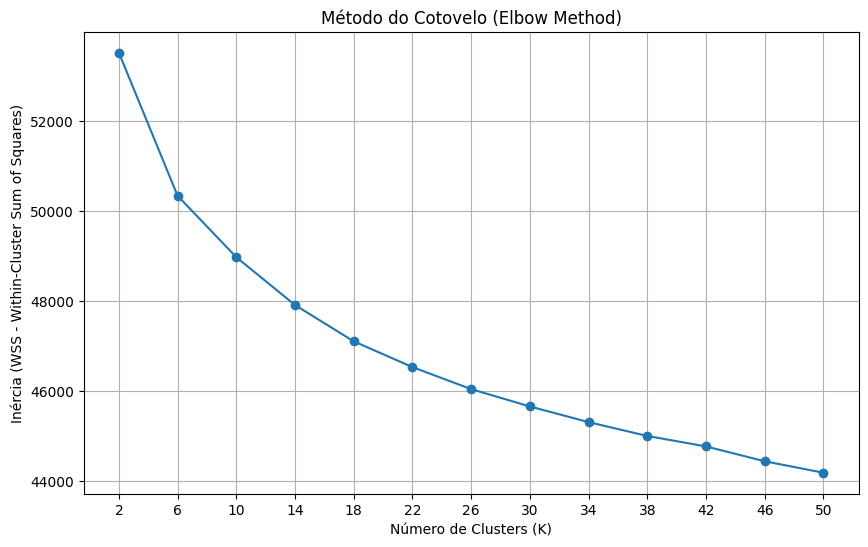


Analise o gráfico acima para identificar um 'cotovelo'.


In [81]:
if can_cluster:
    inertia = [ ]
    # Define um range de K para testar (ajuste o fim do range e o passo se necessário)
    k_range = range( 2, 51, 4 )  # Ex: De 2 a 50, de 4 em 4

    try:
        for k in k_range:
            print( f"  Testando K={k}..." )
            kmeans_elbow = KMeans(
                    n_clusters = k, random_state = 42,
                    n_init = 'auto' )  # n_init='auto' é recomendado nas versões mais recentes
            kmeans_elbow.fit( embeddings_sbert )
            inertia.append( kmeans_elbow.inertia_ )
        print( "Cálculo da inércia concluído." )

        # Plotar o gráfico do cotovelo
        plt.figure( figsize = (10, 6) )
        plt.plot( k_range, inertia, marker = 'o', linestyle = '-' )
        plt.title( 'Método do Cotovelo (Elbow Method)' )
        plt.xlabel( 'Número de Clusters (K)' )
        plt.ylabel( 'Inércia (WSS - Within-Cluster Sum of Squares)' )
        plt.xticks( k_range )
        plt.grid( True )
        plt.show()

        print( "\nAnalise o gráfico acima para identificar um 'cotovelo'." )

    except Exception as e:
        print( f"\nErro ao calcular o Método do Cotovelo: {e}" )

## 6.3 Escolhendo K: Pontuação de Silhueta (Silhouette Score)

Calcula e plota a pontuação média de silhueta para diferentes valores de K. Esta métrica avalia quão bem separados os clusters estão. Valores mais próximos de 1 indicam clusters mais densos e bem definidos. Um pico no gráfico sugere um valor de K ótimo.

  Testando K=2 para Silhueta...
    Calculando score para K=2...
    K=2, Silhouette Score=0.0761
  Testando K=5 para Silhueta...
    Calculando score para K=5...
    K=5, Silhouette Score=0.0523
  Testando K=8 para Silhueta...
    Calculando score para K=8...
    K=8, Silhouette Score=0.0451
  Testando K=11 para Silhueta...
    Calculando score para K=11...
    K=11, Silhouette Score=0.0414
  Testando K=14 para Silhueta...
    Calculando score para K=14...
    K=14, Silhouette Score=0.0413
  Testando K=17 para Silhueta...
    Calculando score para K=17...
    K=17, Silhouette Score=0.0408
  Testando K=20 para Silhueta...
    Calculando score para K=20...
    K=20, Silhouette Score=0.0395
Cálculo da pontuação de silhueta concluído.


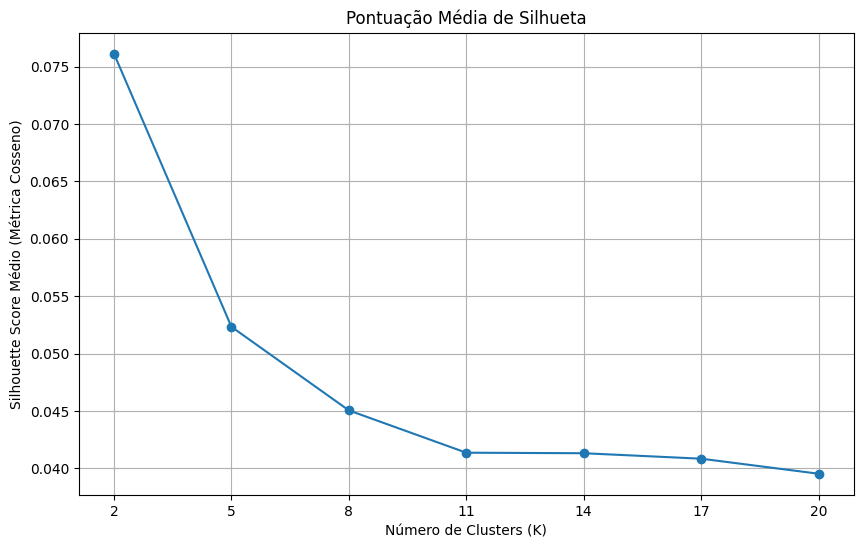


Procure por um pico (valor máximo) no gráfico de silhueta.


In [82]:
if can_cluster:
    calculate_silhouette = True

    if calculate_silhouette:
        silhouette_scores = [ ]
        # Usar um range menor para K devido ao custo
        k_range_silhouette = range( 2, 21, 3 )  # Ex: De 2 a 20, de 3 em 3

        try:
            for k in k_range_silhouette:
                print( f"  Testando K={k} para Silhueta..." )
                kmeans_silhouette = KMeans( n_clusters = k, random_state = 42, n_init = 'auto' )
                cluster_labels_temp = kmeans_silhouette.fit_predict( embeddings_sbert )
                print( f"    Calculando score para K={k}..." )
                score = silhouette_score(
                        embeddings_sbert, cluster_labels_temp, metric = 'cosine', sample_size = 2000,
                        random_state = 42 )
                silhouette_scores.append( score )
                print( f"    K={k}, Silhouette Score={score:.4f}" )
            print( "Cálculo da pontuação de silhueta concluído." )

            # Plotar o gráfico da silhueta
            plt.figure( figsize = (10, 6) )
            plt.plot( k_range_silhouette, silhouette_scores, marker = 'o', linestyle = '-' )
            plt.title( 'Pontuação Média de Silhueta' )
            plt.xlabel( 'Número de Clusters (K)' )
            plt.ylabel( 'Silhouette Score Médio (Métrica Cosseno)' )
            plt.xticks( k_range_silhouette )
            plt.grid( True )
            plt.show()

            print( "\nProcure por um pico (valor máximo) no gráfico de silhueta." )

        except Exception as e:
            print( f"\nErro ao calcular a Pontuação de Silhueta: {e}" )

## 6.4 Treinamento do Modelo K-Means Final

Com base na análise dos gráficos do Cotovelo e/ou da Silhueta, define-se o número final de clusters (K_ESCOLHIDO). Em seguida, treina-se o modelo K-Means definitivo usando todos os embeddings SBERT e o valor de K escolhido.

In [83]:
if can_cluster:
    # --- Definição de K ---
    # Analise os gráficos anteriores e defina o número de clusters desejado.
    K_ESCOLHIDO = 10

    try:
        kmeans = KMeans( n_clusters = K_ESCOLHIDO, random_state = 42, n_init = 'auto' )
        # Treina o modelo com os embeddings SBERT
        kmeans.fit( embeddings_sbert )
        print( "Treinamento K-Means final concluído." )
        clusters_generated = True
    except Exception as e:
        print( f"\nErro ao treinar o K-Means final: {e}" )
        clusters_generated = False
else:
    clusters_generated = False

Treinamento K-Means final concluído.


## 6.5 Atribuição de Rótulos e Análise dos Clusters

Obtém os rótulos de cluster atribuídos a cada filme pelo modelo K-Means treinado. Adiciona esses rótulos como uma nova coluna ao DataFrame principal (`df`). Realiza uma análise básica, mostrando a contagem de filmes por cluster e exibindo os títulos de alguns filmes de exemplo para clusters selecionados, permitindo uma verificação qualitativa da coesão dos grupos formados.

In [84]:
if clusters_generated:
    # --- Obtenção e Adição dos Rótulos ---
    cluster_labels = kmeans.labels_
    df[ 'cluster_sbert' ] = cluster_labels
    print( f"Coluna 'cluster_sbert' adicionada ao DataFrame 'df'." )

    # --- Análise dos Clusters ---
    print( "\nDistribuição de filmes por cluster (contagem):" )
    # Mostra a contagem de filmes em cada cluster, ordenado pelo número do cluster
    print( df[ 'cluster_sbert' ].value_counts().sort_index() )

    print( "\nExemplos de títulos por cluster:" )
    # Define alguns clusters para inspecionar (ex: os primeiros, um do meio, o último)
    clusters_para_inspecionar = list( range( min( 3, K_ESCOLHIDO ) ) )  # Primeiros 3
    if K_ESCOLHIDO > 5: clusters_para_inspecionar.append( K_ESCOLHIDO // 2 )  # Meio
    if K_ESCOLHIDO > 1: clusters_para_inspecionar.append( K_ESCOLHIDO - 1 )  # Último
    clusters_para_inspecionar = sorted( list( set( clusters_para_inspecionar ) ) )  # Remove duplicatas e ordena

    for cluster_num in clusters_para_inspecionar:
        print( f"\n--- Cluster {cluster_num} ---" )
        # Seleciona os primeiros N títulos do cluster atual
        filmes_no_cluster = df[ df[ 'cluster_sbert' ] == cluster_num ][ 'title' ].head( 5 ).tolist()
        if filmes_no_cluster:
            for titulo_filme in filmes_no_cluster:
                print( f"  - {titulo_filme}" )
        else:
            # Isso não deve acontecer se K foi baseado nos dados, mas é uma checagem
            print( "  (Nenhum filme encontrado neste cluster)" )

else:
    print( "\nAnálise de clusters não pode ser realizada (clustering não executado ou falhou)." )

Coluna 'cluster_sbert' adicionada ao DataFrame 'df'.

Distribuição de filmes por cluster (contagem):
cluster_sbert
0     684
1    1025
2    1050
3    1507
4     615
5     973
6     924
7     828
8     880
9    1501
Name: count, dtype: int64

Exemplos de títulos por cluster:

--- Cluster 0 ---
  - Dilwale Dulhania Le Jayenge
  - Spirited Away
  - Your Eyes Tell
  - Your Name.
  - Life Is Beautiful

--- Cluster 1 ---
  - Gabriel's Inferno
  - The Green Mile
  - Woman in the Dunes
  - KonoSuba: God's Blessing on this Wonderful World! Legend of Crimson
  - The Shining

--- Cluster 2 ---
  - Impossible Things
  - Gabriel's Inferno: Part II
  - Gabriel's Inferno: Part III
  - Cinema Paradiso
  - Violet Evergarden: The Movie

--- Cluster 5 ---
  - Evangelion: 3.0+1.0 Thrice Upon a Time
  - Spider-Man: Into the Spider-Verse
  - Neon Genesis Evangelion: The End of Evangelion
  - The Empire Strikes Back
  - Primal: Tales of Savagery

--- Cluster 9 ---
  - The Godfather
  - 12 Angry Men
  - The D

# 7. Recomendação Baseada em Cluster

Nesta seção, define-se e aplica-se a função `recomendar_por_cluster`. A abordagem utiliza os clusters gerados anteriormente (baseados em embeddings SBERT) para sugerir filmes. A ideia é que filmes dentro do mesmo cluster são semanticamente relacionados. As recomendações são então ordenadas pela pontuação de qualidade ('score' - Weighted Rating) para apresentar primeiro os filmes mais relevantes ou populares dentro daquele grupo temático.

## 7.1 Verificação Prévia das Colunas Necessárias

Antes de definir ou usar a função, verifica se as colunas essenciais (`cluster_sbert` e `score`) estão presentes no DataFrame `df`. Isso garante que as etapas anteriores (clustering e cálculo de score) foram executadas com sucesso e informa se a ordenação por score será possível.

In [85]:
# Presume que 'df' existe e contém os dados dos filmes
if 'df' not in globals() or not isinstance( df, pd.DataFrame ):
    print( "Erro: DataFrame 'df' não encontrado." )
    can_recommend_cluster = False
else:
    can_recommend_cluster = True
    # Verifica se a coluna de cluster existe
    if 'cluster_sbert' not in df.columns:
        print( "Erro: Coluna 'cluster_sbert' não encontrada no DataFrame 'df'." )
        print( "Execute a seção de Clustering (7) antes de continuar." )
        can_recommend_cluster = False  # Impede a execução da recomendação

    # Verifica se a coluna de score existe (para ordenação)
    if 'score' not in df.columns:
        print( "\nAviso: Coluna 'score' (Weighted Rating) não encontrada no DataFrame 'df'." )
        print( "As recomendações do cluster não serão ordenadas por qualidade/popularidade." )
        # Cria score padrão apenas para evitar erros na função, se ela for chamada
        df[ 'score' ] = 0.0
        recommend_by_score_possible = False
    elif not pd.api.types.is_numeric_dtype( df[ 'score' ] ):
        print( "\nAviso: Coluna 'score' não é numérica." )
        print( "As recomendações do cluster não serão ordenadas por qualidade/popularidade." )
        recommend_by_score_possible = False
    else:
        print( "\nColunas 'cluster_sbert' e 'score' encontradas. Ordenação por score habilitada." )
        recommend_by_score_possible = True  # Flag indicando que a ordenação por score é viável


Aviso: Coluna 'score' (Weighted Rating) não encontrada no DataFrame 'df'.
As recomendações do cluster não serão ordenadas por qualidade/popularidade.


## 7.2 Definição da Função `recomendar_por_cluster`

Define a função que implementa a lógica de recomendação por cluster. Ela encontra o cluster do filme de entrada, busca outros filmes no mesmo cluster e os ordena pela coluna 'score' antes de retornar os melhores.

In [86]:
def recomendar_por_cluster( titulo, data = df, mapping = indices, top_n = 10 ):
    """
    Gera recomendações de filmes do mesmo cluster do filme de entrada.

    Ordena os filmes do cluster pelo 'score' (Weighted Rating) se disponível e numérico.

    Args:
        titulo (str): Título do filme base.
        data (pd.DataFrame): DataFrame com 'title', 'cluster_sbert', 'score'.
        mapping (pd.Series): Mapeamento título -> índice.
        top_n (int): Número de recomendações.

    Returns:
        list: Lista de títulos recomendados, ou str com erro.
    """
    # Verifica se as dependências estão disponíveis
    if 'cluster_sbert' not in data.columns:
        return "Erro: Coluna 'cluster_sbert' ausente no DataFrame."
    if mapping is None or not isinstance( mapping, pd.Series ):
        return "Erro: Mapeamento 'indices' inválido ou ausente."

    try:
        # Encontra o índice do filme de entrada (com busca flexível)
        if titulo not in mapping:
            matches = [ t for t in mapping.index if t.lower().strip() == titulo.lower().strip() ]
            if not matches: raise KeyError  # Dispara erro se não encontrar
            actual_title = matches[ 0 ]
            idx = mapping[ actual_title ]
        else:
            idx = mapping[ titulo ]

        # Valida o índice
        if idx >= len( data ):
            raise ValueError( f"Índice {idx} fora dos limites para o filme '{titulo}'." )

        # Obtém o cluster e título real do filme de entrada
        input_movie_cluster = data.iloc[ idx ][ 'cluster_sbert' ]
        input_movie_title = data.iloc[ idx ][ 'title' ]
        print( f"\nFilme '{input_movie_title}' (índice {idx}) pertence ao Cluster: {input_movie_cluster}" )

        # Filtra outros filmes do mesmo cluster
        cluster_movies = data[
            (data[ 'cluster_sbert' ] == input_movie_cluster) & (data.index != idx) ].copy()  # Usa .copy()

        if cluster_movies.empty:
            return f"Nenhum outro filme encontrado no Cluster {input_movie_cluster} para recomendar."
        else:
            print( f"Encontrados {len( cluster_movies )} outros filmes no Cluster {input_movie_cluster}." )

        # Ordena por 'score' se a coluna existir, for numérica e a flag global permitir
        # A flag 'recommend_by_score_possible' foi definida na célula anterior
        if recommend_by_score_possible and 'score' in cluster_movies.columns:
            cluster_movies_sorted = cluster_movies.sort_values( 'score', ascending = False )
            print( f"Ordenando recomendações por 'score' (WR)." )
        else:
            cluster_movies_sorted = cluster_movies  # Mantém ordem padrão
            if 'score' not in cluster_movies.columns:
                print( "Ordenação padrão (coluna 'score' ausente)." )
            else:
                print( "Ordenação padrão (coluna 'score' não numérica ou flag desabilitada)." )

        # Seleciona os top_n títulos
        recommendations = cluster_movies_sorted[ 'title' ].head( top_n ).tolist()

        return recommendations

    except KeyError:
        suggestion = [ t for t in mapping.index if titulo.lower() in t.lower() ][ :5 ]
        error_msg = f"Erro: Filme '{titulo}' não encontrado no dataset."
        if suggestion: error_msg += f" Títulos similares: {suggestion}"
        return error_msg
    except ValueError as ve:
        print( f"Erro de valor ao processar filme/cluster: {ve}" )
        return "Não foi possível gerar recomendações devido a um erro interno de dados."
    except Exception as e:
        # Adiciona o tipo de exceção para melhor depuração
        import traceback
        print( f"Erro inesperado em recomendar_por_cluster para '{titulo}': {type( e ).__name__} - {e}" )
        # traceback.print_exc() # Descomente para ver o stack trace completo
        return "Ocorreu um erro inesperado durante a recomendação por cluster."

## 7.3 Aplicação da Recomendação por Cluster

Executa a função `recomendar_por_cluster` para alguns filmes de exemplo e exibe os resultados. Só executa se a etapa de clustering anterior tiver sido concluída com sucesso (verificado pela existência da coluna `cluster_sbert`).

In [87]:
print( "\n--- Testando Recomendações por Cluster ---" )

# Verifica se é possível recomendar (se o clustering foi feito)
if can_recommend_cluster:
    filme_exemplo_cluster_1 = "The Dark Knight Rises"
    print( f"\nExemplo 1: Buscando recomendações para '{filme_exemplo_cluster_1}'" )

    recomendacoes_cluster_1 = recomendar_por_cluster( filme_exemplo_cluster_1, top_n = 10 )

    # Imprime o resultado (lista de filmes ou mensagem de erro)
    if isinstance( recomendacoes_cluster_1, list ):
        if not recomendacoes_cluster_1:
            print( "Nenhuma recomendação encontrada para este filme." )
        else:
            print( "\nRecomendações:" )
            for i, filme in enumerate( recomendacoes_cluster_1 ):
                print( f"  {i + 1}. {filme}" )
    else:
        print( recomendacoes_cluster_1 )  # Exibe a mensagem de erro retornada

    filme_exemplo_cluster_2 = "Avatar"
    print( f"\nExemplo 2: Buscando recomendações para '{filme_exemplo_cluster_2}'" )

    recomendacoes_cluster_2 = recomendar_por_cluster( filme_exemplo_cluster_2, top_n = 10 )

    # Imprime o resultado
    if isinstance( recomendacoes_cluster_2, list ):
        if not recomendacoes_cluster_2:
            print( "Nenhuma recomendação encontrada para este filme." )
        else:
            print( "\nRecomendações:" )
            for i, filme in enumerate( recomendacoes_cluster_2 ):
                print( f"  {i + 1}. {filme}" )
    else:
        print( recomendacoes_cluster_2 )  # Exibe a mensagem de erro retornada

else:
    print( "\nRecomendação por cluster não pode ser executada (etapa de clustering não concluída ou falhou)." )


--- Testando Recomendações por Cluster ---

Exemplo 1: Buscando recomendações para 'The Dark Knight Rises'

Filme 'The Dark Knight Rises' (índice 688) pertence ao Cluster: 9
Encontrados 1500 outros filmes no Cluster 9.
Ordenação padrão (coluna 'score' não numérica ou flag desabilitada).

Recomendações:
  1. The Godfather
  2. 12 Angry Men
  3. The Dark Knight
  4. Pulp Fiction
  5. Once Upon a Time in America
  6. One Flew Over the Cuckoo's Nest
  7. Rear Window
  8. Inception
  9. High and Low
  10. Se7en

Exemplo 2: Buscando recomendações para 'Avatar'

Filme 'Avatar' (índice 1289) pertence ao Cluster: 5
Encontrados 972 outros filmes no Cluster 5.
Ordenação padrão (coluna 'score' não numérica ou flag desabilitada).

Recomendações:
  1. Evangelion: 3.0+1.0 Thrice Upon a Time
  2. Spider-Man: Into the Spider-Verse
  3. Neon Genesis Evangelion: The End of Evangelion
  4. The Empire Strikes Back
  5. Primal: Tales of Savagery
  6. Interstellar
  7. Justice League Dark: Apokolips War
  8